In [1]:
%%time
import csv
import feedparser

def collect_papers(categories, num_papers=300):
    """
    Collects papers based on the queried category and amount written as a response in the Atom 1.0 format
    
    Parameters:
    categories: a string that specifies which category should be queired.
    num_papers: the number of papers to collect from each of the defined categories.
    
    """
    
    all_papers = []

    for category in categories:
        # Define the query for each category that would be queried using ArXiv API(string)
        if category == 'math':
            query_str = 'cat:math.*'
        elif category == 'physics':
            query_str = 'cat:physics.*'
        elif category == 'economics':
            query_str = 'cat:econ.*'

        # The ArXiv API URL for getting the responses
        api_url = f'http://export.arxiv.org/api/query?search_query={query_str}&max_results={num_papers}'

        # Parse the feed from Atom format
        feed = feedparser.parse(api_url)
        papers = feed.entries
        all_papers.extend(papers)

    return all_papers

def save_to_csv(papers, categories, csv_filename='abstract.csv'):
    """
    Saves the papers from the API's responses collected as a csv file named asbtract.csv using the csv library.
    
    Parameters:
    papers: the list of papers that would be saved eventually in the csv file.
    categories: a string that specifies which category should be queired.
    csv_filename: the name of the csv file.
    """
    # opens a csv file called abstract.csv, creates it if it doesn't exist using append mode
    with open(csv_filename, 'a', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)

        # Write the header for the columns
        if csvfile.tell() == 0:
            writer.writerow(['category', 'title', 'abstract'])

        # Write to CSV file
        for category, paper in zip(categories, papers):
            abstract = paper.get('summary', paper.get('description', ''))
            writer.writerow([category, paper.title, abstract])

if __name__ == "__main__":
    categories = ['math', 'physics', 'economics']
    num_papers_per_category = 300

    # Collect and save papers for each category
    papers = collect_papers(categories, num_papers_per_category)
    save_to_csv(papers, categories)


CPU times: user 1.32 s, sys: 87.1 ms, total: 1.41 s
Wall time: 15 s


In [5]:
%%time
import pandas as pd
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.preprocessing import LabelEncoder
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
def lemmatize_text(text):
    """
    Turns all words back to its base dictionary word.
    
    Parameter:
    text: the input text that is turned into the base form.
    
    Example: lemmatize_text("Sleeping")
    "Sleep"
    """
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)

def preprocess_csv(csv_filename='abstract.csv', processed_filename='preprocessed_abstract.csv'):
    """
    Preprocesses the scv file using necessary steps. 1st step is lower casing, 2nd is stop word removal, 
    3rd is lemmatization, 4th is tokenization, 5th is label encoding, 6th is removing unnecessary labels.
    
    Parameters: 
    csv_filename: the name of the csv file
    processed_filename: the name of the preprocessed file
    
    Explanations:
    str.lower(): turns all the string into lowercase
    stop_words: all the stop words from the english stop words in the sklearn library
    str.split: splits the string on text into substrings based on the blank spaces in between texts
    
    """
    
    # Read the CSV file
    df = pd.read_csv(csv_filename)

    # Lowercase conversion to the abstracts
    df['abstract'] = df['abstract'].str.lower()

    # Remove stop words from the abstracts
    stop_words = ENGLISH_STOP_WORDS
    df['abstract'] = df['abstract'].apply(lambda x: ' '.join(word for word in x.split() if word.lower() not in stop_words))
    
    # Apply lemmatization function
    df['abstract'] = df['abstract'].apply(lemmatize_text)
    
    # Tokenization using string split
    df['abstract'] = df['abstract'].apply(str.split)

    # Label encoding for the categories
    category_mapping = {'math': 0, 'physics': 1, 'economics': 2}
    df['category'] = df['category'].map(category_mapping)

    # Remove title column
    df.drop('title', axis=1, inplace=True)

    # Save to the file
    df.to_csv(processed_filename, index=False)

# Execute the function to perform preprocessing
preprocess_csv()


CPU times: user 1.28 s, sys: 72.1 ms, total: 1.36 s
Wall time: 1.52 s


Early stopping in fold 1 with accuracy 0.9889
Fold 1: Accuracy: 0.9889, Precision: 0.9891, Recall: 0.9889, F1 Score: 0.9888
Early stopping in fold 2 with accuracy 0.9778
Fold 2: Accuracy: 0.9778, Precision: 0.9783, Recall: 0.9778, F1 Score: 0.9779
Early stopping in fold 3 with accuracy 0.9889
Fold 3: Accuracy: 0.9889, Precision: 0.9890, Recall: 0.9889, F1 Score: 0.9889
Early stopping in fold 4 with accuracy 0.9778
Fold 4: Accuracy: 0.9778, Precision: 0.9781, Recall: 0.9778, F1 Score: 0.9778
Early stopping in fold 5 with accuracy 0.9500
Fold 5: Accuracy: 0.9500, Precision: 0.9537, Recall: 0.9500, F1 Score: 0.9502

Classification Report - All Folds:
               precision    recall  f1-score   support

        math       0.98      0.97      0.97       300
     physics       0.96      0.99      0.97       300
   economics       0.99      0.97      0.98       300

    accuracy                           0.98       900
   macro avg       0.98      0.98      0.98       900
weighted avg     

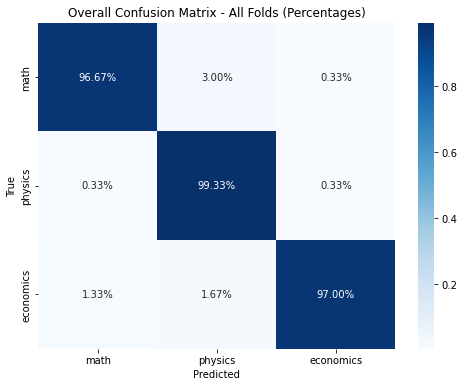

In [7]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Load preprocessed data
df = pd.read_csv('preprocessed_abstract.csv')

# Split data into feature X and label y
X = df['abstract']
y = df['category']

# Vectorize abstract using TF-IDF
vectorizer = TfidfVectorizer()

# Load the Logistic Regression model
logreg_model = LogisticRegression(max_iter=1000)

# Create a pipeline for model and vectorizer
model_pipeline = make_pipeline(vectorizer, logreg_model)

# Amount of folds for cross-validation on the dataset
k = 5

# Lists to store predictions and true labels for all folds
all_val_predictions = []
all_val_labels = []

# Lists to store metrics for each fold
fold_accuracies = []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []

# Early stopping parameters
max_no_improvement = 5

for i, (train_idx, val_idx) in enumerate(StratifiedKFold(n_splits=k, random_state=42, shuffle=True).split(X, y)):
    """
    Perform the k-fold cross-validation using the logistic regression model and
    executes in a loop of each fold and implements early stopping to find
    the best accuracy in each fold where the accuracy stops improving after a certain set of iterations.
    Calculates the metrics of accuracy, precision, recall, f1-score for each folds and reports them
    in a classification report for the combination of all the folds average.

    Parameters:
    train_idx: an index of the training set for the fold
    val_idx: an index of the validation set for the fold

    StratifiedKFold: a variation of k-fold
    Parameters:
    n_splits: the number of splits
    random_state: set the random number generator seed to 42 to get the same splits and reproducibility.
    shuffle: shuffles the contents of the dataset
    """

    # Reset early stopping parameters for each fold
    best_accuracy = 0
    no_improvement = 0

    # Create training and validation sets for split i
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    # Train the model on the training set for the current fold with early stopping
    for epoch in range(100):
        model_pipeline.fit(X_train_fold, y_train_fold)
        val_predictions = model_pipeline.predict(X_val_fold)
        val_accuracy = accuracy_score(y_val_fold, val_predictions)

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            no_improvement = 0
        else:
            no_improvement += 1

        if no_improvement >= max_no_improvement:
            print(f'Early stopping in fold {i + 1} with accuracy {best_accuracy:.4f}')
            break

    # Append predictions and true labels for the current fold
    all_val_predictions.extend(val_predictions)
    all_val_labels.extend(y_val_fold)

    # Calculate metrics for the current fold
    fold_accuracy = accuracy_score(y_val_fold, val_predictions)
    fold_precision = precision_score(y_val_fold, val_predictions, average='weighted')
    fold_recall = recall_score(y_val_fold, val_predictions, average='weighted')
    fold_f1 = f1_score(y_val_fold, val_predictions, average='weighted')

    # Append metrics for the current fold
    fold_accuracies.append(fold_accuracy)
    fold_precisions.append(fold_precision)
    fold_recalls.append(fold_recall)
    fold_f1_scores.append(fold_f1)

    print(f'Fold {i + 1}: Accuracy: {fold_accuracy:.4f}, Precision: {fold_precision:.4f}, Recall: {fold_recall:.4f}, F1 Score: {fold_f1:.4f}')

# Calculate total confusion matrix
overall_cm = confusion_matrix(all_val_labels, all_val_predictions, labels=df['category'].unique())

# Calculate average from appended metrics
average_accuracy = np.mean(fold_accuracies)
average_precision = np.mean(fold_precisions)
average_recall = np.mean(fold_recalls)
average_f1 = np.mean(fold_f1_scores)

# Display classification report for all folds with original labels
class_labels = ['math', 'physics', 'economics']
print('\nClassification Report - All Folds:\n', classification_report(all_val_labels, all_val_predictions, labels=df['category'].unique(), target_names=class_labels))

# Plot the confusion matrix for all folds with original labels as percentages
plt.figure(figsize=(8, 6))
sns.heatmap(overall_cm / overall_cm.sum(axis=1)[:, np.newaxis], annot=True, fmt='.2%', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Overall Confusion Matrix - All Folds (Percentages)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()